In [1]:
%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

if sys.version_info[0] ==3:
    import pickle
else:
    import cPickle as pickle
import errno

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT, SRWLOptMirPl, SRWLOptCryst

#import SRW auxiliary functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh, plot_1d, plot_2d

from wpg.wpg_uti_wf import propagate_wavefront
from wpg.wpg_uti_oe import show_transmission

#from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront

#Import base beamline class and OE wrappers
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
from wpg.optical_elements import Drift, Aperture, Lens,Mirror_elliptical, WF_dist, calculateOPD

#Gaussian beam generator
from wpg.generators import build_gauss_wavefront, build_gauss_wavefront_xy

plt.ion()

In [3]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011

    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def _save_object(obj, file_name):
    """
    Save any python object to file.

    :param: obj : - python objest to be saved
    :param: file_name : - output file, wil be overwrite if exists
    """
    with open(file_name,'wb') as f:
        pickle.dump(obj, f)

def _load_object(file_name):
    """
    Save any python object to file.

    :param: file_name : - output file, wil be overwrite if exists
    :return: obj : - loaded pthon object
    """
    res = None
    with open(file_name,'rb') as f:
        res = pickle.load(f)

    return res

def mkdir_p(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise


*****defining initial wavefront and writing electric field data to h5-file...
sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.499788231945866, 27.079931842197144,2.9970290603902483
save hdf5: g6_742kev.h5
done
FWHMx [mm]: 0.70276295188322
FWHMy [mm]: 0.70276295188322
Coordinates of center, [mm]: -0.0005236683695106648 -0.0005236683695106648
stepX, stepY [um]: 1.0473367390211923 1.0473367390211923 

Total power (integrated over full range): 9.79805 [GW]
Peak power calculated using FWHM:         9.79246 [GW]
Max irradiance: 17.4273 [GW/mm^2]
R-space
FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: 0.70276295188322, 2.9904806463115747


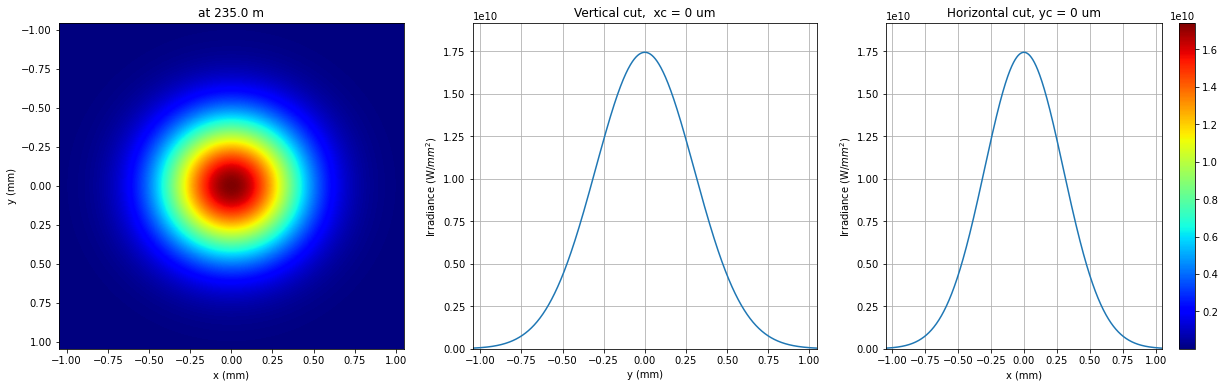

In [4]:
print('*****defining initial wavefront and writing electric field data to h5-file...')
strDataFolderName = 'WPG_output' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

ekev = 6.742 # Energy [keV]
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
#pulse_duration = 9.e-15;
pulse_duration = 50.e-15;
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = 0.24e-15

''' distance to first OE '''
z1 = 235.0

theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('sigX, waist_fwhm [um], far field theta_fwhms [urad]: {}, {},{}'.format(
                            sigX*1e6, sigX*k*1e6, theta_fwhm*1e6)
      )
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size

''' input dimensions '''
npoints=2000

wfr0 = build_gauss_wavefront_xy(npoints, npoints, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,sigX, sigX, z1,
                                pulseEn=pulseEnergy, pulseTau=coh_time/np.sqrt(2),
                                repRate=1/(np.sqrt(2)*pulse_duration))

mwf = Wavefront(wfr0)
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
ename = str(int(ip))+'_'+str(int(frac))+'kev'
fname0 = 'g' + ename
ifname = os.path.join(strDataFolderName,fname0+'.h5')
print('save hdf5: '+fname0+'.h5')
mwf.store_hdf5(ifname)
print('done')

pow_x=plot_wfront(mwf, 'at '+str(z1)+' m',False, False, 1e-5,1e-5,'x', True, saveDir='./'+strDataFolderName)
plt.set_cmap('jet') #set color map, 'bone', 'hot', 'jet', etc
plt.colorbar()
plt.savefig('WPG_Plots/Gaussian beam source.png',transparent=True)
fwhm_x = calculate_fwhm_x(mwf);fwhm_y = calculate_fwhm_y(mwf)
print('FWHMx [mm], theta_fwhm=fwhm_x/z1 [urad], distance to waist: {}, {}'.format(
        fwhm_x*1e3,fwhm_x/z1*1e6)
      )

mwf_backup = mwf

In [5]:
print(pow_x[:,1].max())
print ('I_o {} [GW/mm^2]'.format((pow_x[:,1].max()*1e-9)))
print ('peak power {} [GW]'.format((pow_x[:,1].max()*1e-9*1e6*2*np.pi*(fwhm_x/2.35)**2)))

print('{} slices'.format(mwf.params.Mesh.nSlices))

17427292160.0
I_o 17.42729216 [GW/mm^2]
peak power 9.79245924084223 [GW]
1 slices


Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005
	Dy = 0.005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.0025
		xStart = -0.0025
		yFin = 0.0025
		yStart = -0.0025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 10
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx  2000  range_x [-1.0e+00, 1.0e+00] mm
ny  2000  range_y [-1.0e+00, 1.0e+00] mm
*****propagating wavefront (with resizing)...
done
propagation lasted: 0.1 min
R-space
R-space
Optical Element: Aperture / Obstacle
Prop. parameters = 

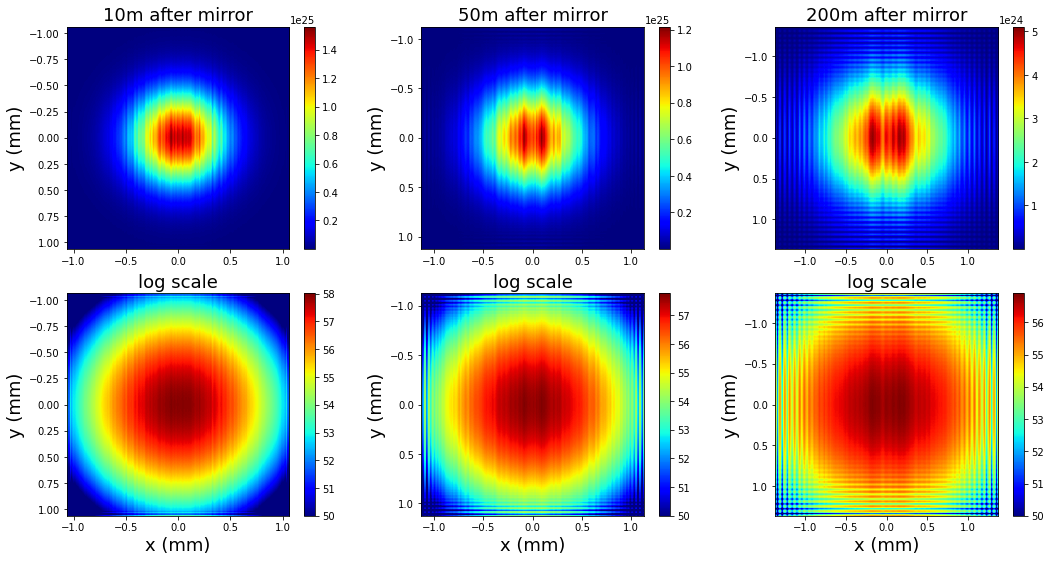

In [40]:
%autoreload 2
from Optics import *

# loop through propagation distance
''' sampling parameters '''
E = ekev*1000
Mirror_width = 5e-3      # physical size of Mirror aperture

nx = 2000; ny = nx     # number of points in H and V

# initialize Mirror container
Mirror_Apt = SRWLOptA('r','a',Mirror_width,Mirror_width)
#Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_Fx=f,_Fy=f,_x=0,_y=0,_eStart=E,_eFin=E)  # Fx given if lens
Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_x=0,_y=0,_eStart=E,_eFin=E)              # Fx not given if aperture

Mirror_x = np.linspace(-Mirror_width/2,Mirror_width/2,nx)
Mirror_y = np.linspace(-Mirror_width/2,Mirror_width/2,ny)
Mirror_x, Mirror_y = np.meshgrid(Mirror_x,Mirror_y)

Mirror_z= Flat_Mirror(Mirror_x,Mirror_y)

''' mirror variable '''
theta = 2e-3
orientation = 'horizontal'

''' mirror error '''
mir_x = np.loadtxt('mirror1.dat')[:,0]
mir_z = np.loadtxt('mirror1.dat')[:,1]
mir_l = (mir_x.max() - mir_x.min())*1e-3
Nrep = int(np.floor(Mirror_width/mir_l)+1)
mir_z = np.tile(mir_z,Nrep)
mir_x = np.linspace(mir_x.min()*Nrep,mir_x.max()*Nrep,mir_z.size) * 1e-3
err = np.interp(Mirror_x[0],mir_x,mir_z)

err = np.repeat([err],nx,axis=0)
if orientation == 'vertical':
    err = err.T
    
err_amp = 1
Mirror_z = Flat_Mirror(Mirror_x, Mirror_y)
Mirror_z += err*err_amp

Calc_OPD_and_AmpTr_Mirror(Mirror_Tr, Mirror_z, theta)

OPD_show = np.array(Mirror_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(Mirror_Tr.arTr)[0::2].reshape(ny,nx)

plt.figure(figsize=(18,9))
for irun, z2 in enumerate([10,50,200]):
    ''' propagation '''
    z2 = z2                # propagation distance from mirror to aperture and lens
    z3 = f_lens            # propagation distance after lens (to focal plane)
    optBL0 = Beamline()
    optBL0.append(Mirror_Apt,    Use_PP())
    optBL0.append(Mirror_Tr,     Use_PP())
    optBL0.append(Drift(z2),     Use_PP(semi_analytical_treatment=1))

    bl = optBL0
    out_file_name = None
    startTime = time.time()
    mwf_mirror = propagate_wavefront(ifname, bl,out_file_name)
    print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

    ''' plot '''
    intensity_lens = mwf_lens.get_intensity(slice_number=0)
    [xmin, xmax, ymin, ymax] = mwf_lens.get_limits()
    d_fov = 60e-6
    xx = np.linspace(xmin,xmax,npoints)
    roi = np.abs(xx)<=d_fov/2
    xx_plot = xx[roi]
    lineout = intensity_lens[int(npoints/2),:]
    lineout_plot = lineout[roi]

    [xmin, xmax, ymin, ymax] = mwf_mirror.get_limits()
    plt.subplot(2,3,irun+1)
    plt.imshow(mwf_mirror.get_intensity(slice_number=0),cmap='jet',
              extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
    plt.colorbar()
    plt.title('{}m after mirror'.format(z2),fontsize=18)
    plt.ylabel('y (mm)',fontsize=18)

    plt.subplot(2,3,irun+4)
    plt.imshow(
        np.log(mwf_mirror.get_intensity(slice_number=0)),cmap='jet',clim=50,
        extent=[xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
    plt.colorbar()
    plt.title('log scale',fontsize=18)
    plt.xlabel('x (mm)',fontsize=18)
    plt.ylabel('y (mm)',fontsize=18)

plt.savefig(strDataFolderName+'/demo/demo_flat_mirror_dif_prop_dist.png',transparent=True)

Aperture (500.0um) and lens at 435.0m
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005
	Dy = 0.005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.0025
		xStart = -0.0025
		yFin = 0.0025
		yStart = -0.0025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 200.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0005
	Dy = 0.0005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0,

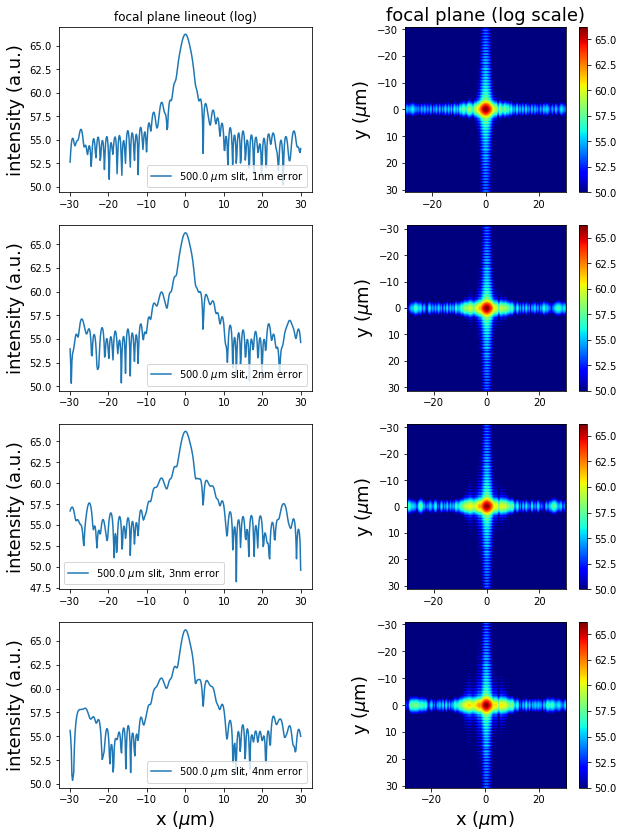

In [45]:
%autoreload 2
from Optics import *

# loop through mirror error
''' sampling parameters '''
E = ekev*1000
Mirror_width = 5e-3      # physical size of Mirror aperture

nx = 2000; ny = nx     # number of points in H and V

# initialize Mirror container
Mirror_Apt = SRWLOptA('r','a',Mirror_width,Mirror_width)
#Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_Fx=f,_Fy=f,_x=0,_y=0,_eStart=E,_eFin=E)  # Fx given if lens
Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_x=0,_y=0,_eStart=E,_eFin=E)              # Fx not given if aperture

Mirror_x = np.linspace(-Mirror_width/2,Mirror_width/2,nx)
Mirror_y = np.linspace(-Mirror_width/2,Mirror_width/2,ny)
Mirror_x, Mirror_y = np.meshgrid(Mirror_x,Mirror_y)

Mirror_z= Flat_Mirror(Mirror_x,Mirror_y)

''' Aperture parameter '''
Apt_dx = 500e-6
Apt_dy = Apt_dx
z_Apt = 200.0
Apt = SRWLOptA('r','a',Apt_dx,Apt_dy)
print('Aperture ({}um) and lens at {}m'.format(Apt_dx*1e6, z1+z_Apt))

''' lens parameter '''
n = 1 - 5.89e-6           # material refractive index
d_abs = 788e-6        # material absorption depth

Lens_width = 0.5e-3
f_lens = 3.0

Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(nx,ny,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=E,_eFin=E)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,nx)
Lens_y = np.linspace(-Lens_width/2,Lens_width/2,ny)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_y)

Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)

Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

''' mirror variable '''
theta = 2e-3
orientation = 'horizontal'

''' mirror error '''
mir_x = np.loadtxt('mirror1.dat')[:,0]
mir_z = np.loadtxt('mirror1.dat')[:,1]
mir_l = (mir_x.max() - mir_x.min())*1e-3
Nrep = int(np.floor(Mirror_width/mir_l)+1)
mir_z = np.tile(mir_z,Nrep)
mir_x = np.linspace(mir_x.min()*Nrep,mir_x.max()*Nrep,mir_z.size) * 1e-3
err = np.interp(Mirror_x[0],mir_x,mir_z)

err = np.repeat([err],nx,axis=0)
if orientation == 'vertical':
    err = err.T

plt.figure(figsize=(10,14))
for irun, err_amp in enumerate(np.arange(4)+1):
    Mirror_z = Flat_Mirror(Mirror_x, Mirror_y)
    Mirror_z += err*err_amp

    Calc_OPD_and_AmpTr_Mirror(Mirror_Tr, Mirror_z, theta)

    OPD_show = np.array(Mirror_Tr.arTr)[1::2].reshape(ny,nx)
    AmpTr_show = np.array(Mirror_Tr.arTr)[0::2].reshape(ny,nx)

    ''' propagation '''
    z2 = z_Apt             # propagation distance from mirror to aperture and lens
    z3 = f_lens            # propagation distance after lens (to focal plane)
    optBL1 = Beamline()
    optBL1.append(Mirror_Apt,    Use_PP())
    optBL1.append(Mirror_Tr,     Use_PP())
    optBL1.append(Drift(z2),     Use_PP(semi_analytical_treatment=1))
    optBL1.append(Apt,           Use_PP())
    optBL1.append(Lens_Apt,      Use_PP())
    optBL1.append(Lens_Tr,       Use_PP())
    optBL1.append(Drift(z3),     Use_PP(semi_analytical_treatment=1))

    bl = optBL1
    out_file_name = None
    startTime = time.time()
    mwf_lens = propagate_wavefront(ifname, bl,out_file_name)
    print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

    ''' plot '''
    # focused beam
    intensity_lens = mwf_lens.get_intensity(slice_number=0)
    [xmin, xmax, ymin, ymax] = mwf_lens.get_limits()
    d_fov = 60e-6
    xx = np.linspace(xmin,xmax,npoints)
    roi = np.abs(xx)<=d_fov/2
    xx_plot = xx[roi]
    lineout = intensity_lens[int(npoints/2),:]
    lineout_plot = lineout[roi]

    plt.subplot(4,2,2*irun+1)
    plt.plot(xx_plot*1e6,np.log(lineout_plot),label='{} $\mu$m slit, {}nm error'.format(round(Apt_dx*1e6,1),err_amp))
    plt.legend()
    if irun == 3:
        plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel('intensity (a.u.)',fontsize=18)
    if irun == 0:
        plt.title(r'focal plane lineout (log)')
    
    plt.subplot(4,2,2*irun+2)
    roi_ratio = d_fov/(xmax-xmin)
    roixi = int(nx*(1-roi_ratio)/2); roixf = int(nx*(1+roi_ratio)/2)
    roiyi = int(ny*(1-roi_ratio)/2); roiyf = int(ny*(1+roi_ratio)/2)

    xlimi = xmin*roi_ratio; xlimf = xmax*roi_ratio
    ylimi = ymin*roi_ratio; ylimf = ymax*roi_ratio
    plt.imshow(
        np.log(intensity_lens)[roixi:roixf,roiyi:roiyf],cmap='jet',clim=50,
        extent=[xlimi*1e6, xlimf*1e6, ylimi*1e6, ylimf*1e6])
    plt.colorbar()
    if irun == 0:
        plt.title('focal plane (log scale)',fontsize=18)
    if irun == 3:
        plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)

plt.savefig(strDataFolderName+'/demo/demo_flat_mirror_focusing_w_dif_mir_err.png',
           transparent=True)

Aperture (50.0um) and lens at 435.0m
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005
	Dy = 0.005
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 8000000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 6742.0
		eStart = 6742.0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 2000
		ny = 2000
		xFin = 0.0025
		xStart = -0.0025
		yFin = 0.0025
		yStart = -0.0025
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 200.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 5e-05
	Dy = 5e-05
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0,

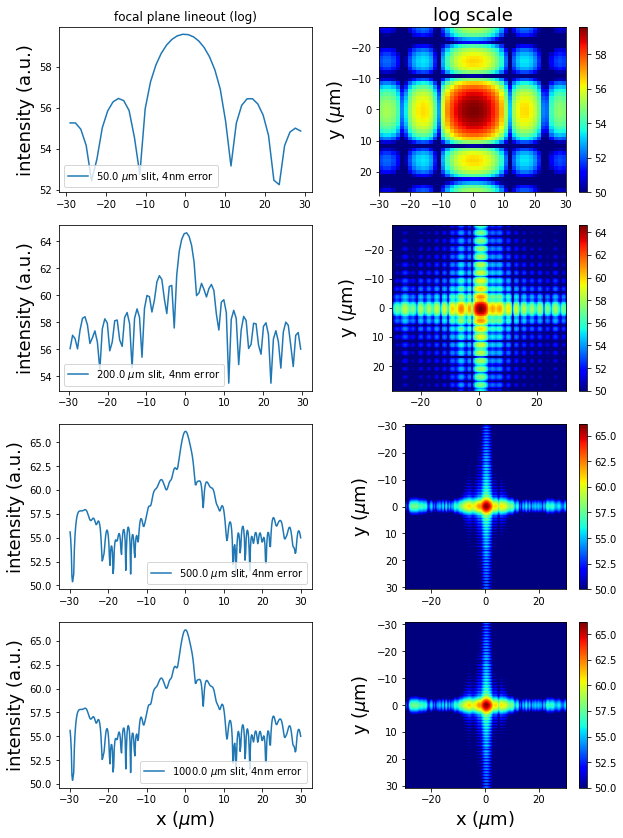

In [46]:
%autoreload 2
from Optics import *

# loop through slit width
''' sampling parameters '''
E = ekev*1000
Mirror_width = 5e-3      # physical size of Mirror aperture

nx = 2000; ny = nx     # number of points in H and V

# initialize Mirror container
Mirror_Apt = SRWLOptA('r','a',Mirror_width,Mirror_width)
#Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_Fx=f,_Fy=f,_x=0,_y=0,_eStart=E,_eFin=E)  # Fx given if lens
Mirror_Tr = SRWLOptT(nx,ny,Mirror_width,Mirror_width,_x=0,_y=0,_eStart=E,_eFin=E)              # Fx not given if aperture

Mirror_x = np.linspace(-Mirror_width/2,Mirror_width/2,nx)
Mirror_y = np.linspace(-Mirror_width/2,Mirror_width/2,ny)
Mirror_x, Mirror_y = np.meshgrid(Mirror_x,Mirror_y)

Mirror_z= Flat_Mirror(Mirror_x,Mirror_y)

''' mirror variable '''
theta = 2e-3
orientation = 'horizontal'

''' mirror error '''
mir_x = np.loadtxt('mirror1.dat')[:,0]
mir_z = np.loadtxt('mirror1.dat')[:,1]
mir_l = (mir_x.max() - mir_x.min())*1e-3
Nrep = int(np.floor(Mirror_width/mir_l)+1)
mir_z = np.tile(mir_z,Nrep)
mir_x = np.linspace(mir_x.min()*Nrep,mir_x.max()*Nrep,mir_z.size) * 1e-3
err = np.interp(Mirror_x[0],mir_x,mir_z)

err = np.repeat([err],nx,axis=0)
if orientation == 'vertical':
    err = err.T

err_map = 1
Mirror_z = Flat_Mirror(Mirror_x, Mirror_y)
Mirror_z += err*err_amp

Calc_OPD_and_AmpTr_Mirror(Mirror_Tr, Mirror_z, theta)

OPD_show = np.array(Mirror_Tr.arTr)[1::2].reshape(ny,nx)
AmpTr_show = np.array(Mirror_Tr.arTr)[0::2].reshape(ny,nx)

''' lens parameter '''
n = 1 - 5.89e-6           # material refractive index
d_abs = 788e-6        # material absorption depth

Lens_width = 0.5e-3
f_lens = 3.0

Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(nx,ny,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=E,_eFin=E)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,nx)
Lens_y = np.linspace(-Lens_width/2,Lens_width/2,ny)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_y)

Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)

Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

''' Aperture parameter '''
z_Apt = 200.0

plt.figure(figsize=(10,14))
for irun, Apt_dx in enumerate([50e-6,200e-6,500e-6,1000e-6]): 
    Apt_dy = Apt_dx
    Apt = SRWLOptA('r','a',Apt_dx,Apt_dy)
    print('Aperture ({}um) and lens at {}m'.format(Apt_dx*1e6, z1+z_Apt))

    ''' propagation '''
    z2 = z_Apt             # propagation distance from mirror to aperture and lens
    z3 = f_lens            # propagation distance after lens (to focal plane)
    optBL1 = Beamline()
    optBL1.append(Mirror_Apt,    Use_PP())
    optBL1.append(Mirror_Tr,     Use_PP())
    optBL1.append(Drift(z2),     Use_PP(semi_analytical_treatment=1))
    optBL1.append(Apt,           Use_PP())
    optBL1.append(Lens_Apt,      Use_PP())
    optBL1.append(Lens_Tr,       Use_PP())
    optBL1.append(Drift(z3),     Use_PP(semi_analytical_treatment=1))

    bl = optBL1
    out_file_name = None
    startTime = time.time()
    mwf_lens = propagate_wavefront(ifname, bl,out_file_name)
    print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

    ''' plot '''
    # focused beam
    intensity_lens = mwf_lens.get_intensity(slice_number=0)
    [xmin, xmax, ymin, ymax] = mwf_lens.get_limits()
    d_fov = 60e-6
    xx = np.linspace(xmin,xmax,npoints)
    roi = np.abs(xx)<=d_fov/2
    xx_plot = xx[roi]
    lineout = intensity_lens[int(npoints/2),:]
    lineout_plot = lineout[roi]

    plt.subplot(4,2,2*irun+1)
    plt.plot(xx_plot*1e6,np.log(lineout_plot),label='{} $\mu$m slit, {}nm error'.format(round(Apt_dx*1e6,1),err_amp))
    plt.legend()
    if irun == 3:
        plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel('intensity (a.u.)',fontsize=18)
    if irun == 0:
        plt.title(r'focal plane lineout (log)')
    
    plt.subplot(4,2,2*irun+2)
    roi_ratio = d_fov/(xmax-xmin)
    roixi = int(nx*(1-roi_ratio)/2); roixf = int(nx*(1+roi_ratio)/2)
    roiyi = int(ny*(1-roi_ratio)/2); roiyf = int(ny*(1+roi_ratio)/2)

    xlimi = xmin*roi_ratio; xlimf = xmax*roi_ratio
    ylimi = ymin*roi_ratio; ylimf = ymax*roi_ratio
    plt.imshow(
        np.log(intensity_lens)[roixi:roixf,roiyi:roiyf],cmap='jet',clim=50,
        extent=[xlimi*1e6, xlimf*1e6, ylimi*1e6, ylimf*1e6])
    plt.colorbar()
    if irun == 0:
        plt.title('log scale',fontsize=18)
    if irun == 3:
        plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)

plt.savefig(strDataFolderName+'/demo/demo_flat_mirror_focusing_w_dif_slit_width.png',
           transparent=True)